# Vežbe 2 - OCR (Optical character recognition)

Cilj ovih vežbi je implementacija osnovne verzije OCR-a i upoznavanje sa Keras okruženjem za rad sa neuronskim mrežama.

* Keras - Python biblioteka za laku implementaciju neuronski mreža (http://keras.io/)



### Tok aktivnosti implementacije OCR - a 

Tok aktivnosti predstavlja korake koje je potrebno izvršiti prilikom implementacije OCR-a.

<img src="images/Tok aktivnosti.png">

### Početak implementacije
Skup biblioteka sa prethodnih vežbi smo proširili Keras bibliotekom za rad sa neuronskim mrežama.

In [2]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

Using Theano backend.


## Korak 1 - 3
Ovi koraci su detaljno objašnjeni na prethodnim vežbama, tako da neće biti dodatno objašnjavani

In [3]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

### Korak 4 -  izdvajanje regiona od interesa

U ovom koraku potrebno je izdvojiti samo regione(konture) od interesa. Potrebno je označiti regione od interesa na slici i napraviti listu slika od regiona koja će kasnije biti ulaz za neuronsku mrežu.

### TODO 1
Za potrebe TODO 1 implementirati funkciju za promenu veličine slike na 28 x 28. Ovo se radi kako bi svi regioni koje ćemo koristiti za neuronsku mrežu bili iste veličine. *(pomoć: pogledati OpenCV funkciju resize)*

In [4]:
# TODO 1 
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

# TODO 1 test
todo_1_img = load_image('images/todo_1_test.png')
todo_1_ref = (28,28)
todo_1_res = resize_region(todo_1_img).shape[0:2]
print 'TODO 1 test passed:', todo_1_res == todo_1_ref

TODO 1 test passed: True


### TODO 2
* Označiti regione od interesa na originalnoj slici.
* Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
* Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
* Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni (koristiti OpenCV funkciju **rectangle**) i niz slika koje predstavljaju regione sortirane  po rastućoj vrednosti x ose

In [5]:
# TODO 2
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y+h+1,x:x+w+1];
            regions_dic[x] = resize_region(region)       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

## Korak 5

Regioni od interesa su predstavljeni vektorom čiji su elementi matrice dimenzija 28x28. Elementi matrica su vrednosti 0 ili 255. Potrebno je skalirati vrednosti elemenata matrice na opseg od 0 do 1, kako bi se pogodio linearni deo sigmoid funkcije i smanjilo vreme obučavanja.
Nakon skaliranja matrice je potrebno transformisati u vektor od 784 elementa.

###TODO 3

Skalirati sve elemente matrice sa celobrojnog opsega [0, 255] na realni opseg [0, 1].

In [6]:
# TODO 3
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255

# TODO 3 test
todo_3_matrix = np.array([[0, 255], [51, 153]], dtype='float')
todo_3_ref = np.array([[0., 1.], [0.2, 0.6]], dtype='float')
todo_3_res = scale_to_range(todo_3_matrix)
print 'TODO 3 test passed:', np.array_equal(todo_3_res, todo_3_ref)

TODO 3 test passed: True


###TODO 4

Region koji je zapravo slika (matrica) dimenzija 28x28 transformiati u vektor od 784 elementa.

In [7]:
# TODO 4
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()

# TODO 4 test
todo_4_image = np.ndarray((28,28))
todo_4_ref = (784L,)
todo_4_res = matrix_to_vector(todo_4_image).shape
print 'TODO 4 test passed:', todo_4_res == todo_4_ref

TODO 4 test passed: True


###TODO 5

Svaki region pripremiti za ulaz na neuronsku mrežu: skaliranje elemenata na [0,1] i transformaciju u vektor.

In [8]:
# TODO 5
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

###TODO 6

Konvertovati alfabet u niz pogodan za obučavanje NM, odnosno niz čiji su svi elementi 0 osim elementa čiji je indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0], za drugi [0,1,0,0,0,0,0,0,0,0] itd..

In [9]:
# TODO 6
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

# TODO 6 test
test_6_alphabet = [0, 1, 2]
test_6_ref = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype='float')
test_6_res = convert_output(test_6_alphabet).astype('float')
print 'TODO 6 test passed:', np.array_equal(test_6_res, test_6_ref)

TODO 6 test passed: True


##Korak 6

### Neuronska mreža

Veštačka neuronska mreža se sastoji od 784 ulazna neurona, 128 neurona u skrivenom sloju i 10 neurona na izlazu. Zašto baš 784 neurona na ulazu i 10 neurona na izlazu? Regione smo transformisali prvo na matricu dimenzija 28x28,a zatim u vektor od 784 elementa. Što se tiče 10 neurona na izlazu, to je posledica broja znakova u alfabetu. U našem primeru alfabet (0,1,2,3,4,5,6,7,8,9) ima 10 elemenata pa nam je potrebno 10 neurona na izlazu.
Neuronska mreža je implementirana pomoću Keras biblioteke.
<img src="images/neuronska_mreza.png">

### Sigmoidalna aktivaciona funkcija
$ sigm(x) = \dfrac{1}{1 + e^{-x}} $

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/2000px-Logistic-curve.svg.png" width="300" height="300">

In [10]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=2000, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

##Korak 7 - određivanje pobedničkog neurona

Određivanje pobedničkog neurona. Pobednički neuron je neuron čija je aktivaciona vrednost najveća. Npr. ako imamo dva neurona sa aktivacionim vrednostima 0.3 i 0.89, pobednik je drugi sa aktivacijom 0.89.

##TODO 7

Pronaći indeks neurona koji je najviše pobuđen.


In [11]:
# TODO 7
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

# TODO 7 test
todo_7_output = [0., 0.2, 0.3, 0.95]
todo_7_ref = 3
todo_7_res = winner(todo_7_output)
print 'TODO 7 test passed:', todo_7_res == todo_7_ref

TODO 7 test passed: True


##Korak 8 - prikaz rezultata

Pikazati rezultat prepoznavanja neuronske mreže. Za svaki rezultat pronaći indeks pobedničkog  neurona koji ujedno predstavlja i indeks prepoznatog elementa u alfabetu. Dodati karakter iz alfabeta u result

In [12]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

## Start
Učitati sliku za obučavanje veštačke neuronske mreže. Transformisati sliku i binarni oblik i označiti regione od interesa (u ovom slučaju to su brojevi od 0 do 9).
Prikazati sliku sa označenim regionima od interesa.

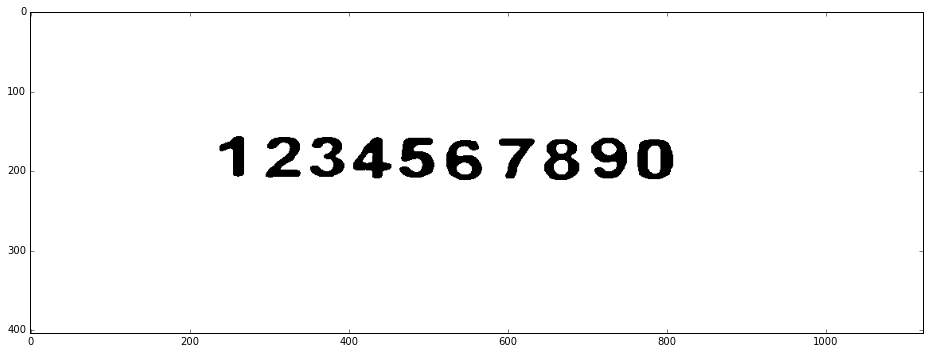

In [27]:
image_color = load_image('images/brojevi2.png')
img = invert(image_bin(image_gray(image_color)))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img)
display_image(selected_regions)
display_image(img_bin)


In [23]:
# insert alphabet here
alphabet = [1,2,3,4,5,6,7,8,9,0]

In [22]:
inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

### Verifikacija i primer predikcije

Za verifikaciju obučenosti neuronske mreže ćemo uzeti drugi i treći ulazni vektor (brojevi 3 i 4 iz alfabeta).
Metoda **model.predict** kao ulazni parametar prima niz vektora dimenzija 784.
Rezultat **predict** metode je niz vektora dimenzije 10, koji sadrži koeficijente pobuđenosti.

In [24]:
result = ann.predict(np.array(inputs[2:4], np.float32))
print result
print display_result(result, alphabet)

[[ 0.01678181  0.02044868  0.95596683  0.00772037  0.01641213  0.0037591
   0.01723692  0.02365533  0.0186955   0.00962151]
 [ 0.0195286   0.01354386  0.00618766  0.96569401  0.01463024  0.01111767
   0.0190946   0.01800523  0.00186442  0.00779148]]
[3, 4]


## TODO 8

Učitati sliku za testiranje rada OCR -a  'images/test.png'. Transformisati sliku u oblik pogodan za ulaz u neuronsku mrežu. 
Prikazati rezultate predikcije kao i sliku sa označenim regionima od interesa.

PSEUDO KOD:
* učitati sliku 'images/test.png'
* pretvoriti sliku u binarnu i ako je potrebno invertovati je
* ako je potrebno primeniti eroziju i/ili diletaciju
* selektovati regione od značaja
* pripremiti podatke za ulaz na NM
* pozvati metodu **predict**, a kao parametar proslediti pripremljene podatke
* prikazati rezultate predikcije


[2, 5, 1, 9, 6, 4, 2, 0, 3, 7, 5]


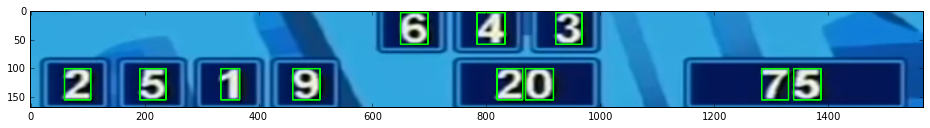

In [292]:
# TODO 8
test_color = load_image('images/slagalica8.png')
test = invert(image_bin(image_gray(test_color)))
#test_bin = erode(dilate(erode((dilate(dilate(erode(dilate(dilate(dilate(dilate(erode(erode(erode(dilate(test)))))))))))))))


display_image(test)

for i in range (1,50):
    test =erode(dilate(test))

for i in range (1,4):
    test=dilate(test)
    
for i in range (1,7):
    test=erode(test)

for i in range (1,3):
    test=dilate(test)
    
for i in range (1,1):
    test=erode(test)


test_bin=test

selected_test, test_numbers = select_roi(test_color.copy(),test_bin)
display_image(selected_test)
test_inputs = prepare_for_ann(test_numbers)
result = ann.predict(np.array(test_inputs, np.float32))

print display_result(result, alphabet)
trazeni_broj= 100*alphabet[winner(result[4])] + 10*alphabet[winner(result[5])] + alphabet[winner(result[8])]
b1=alphabet[winner(result[0])]
b2=alphabet[winner(result[1])]
b3=alphabet[winner(result[2])]
b4=alphabet[winner(result[3])]
b5=10*alphabet[winner(result[6])]+alphabet[winner(result[7])]
if alphabet[winner(result[9])]==1:
    b6=100
else:
    b6=10*alphabet[winner(result[9])]+alphabet[winner(result[10])]



def izracunaj(sum,br,t,s):
    
    for idx,value in enumerate(br):
        if value== t:
            s+=str(value)
            sum+=value
            print s
            return
        else:
            br2=[]
            br.remove(value)
            br2=br
            #sum=
            #for idx,value in enumerate(br2):
             #   if sum+value==t:
                    
            br.insert(idx,value)
            
    
    return   

br=[]
br.append(b1)
br.append(b2)
br.append(b3)
br.append(b4)
br.append(b5)
br.append(b6)

s=""
#izracunaj(0,br,trazeni_broj,s)

#izracunaj (b1,b2,b3,b4,b5,b6,99)
        

### TODO dodatno

Implementirati kalkulator. Alfabet za kalkulator i test primeri se nalaze u 'images/kalkulator_alfabet.png'.

In [293]:
# TODO dodatno - kalkulator
# PSEUDO KOD
# UČITATI ALFABET ZA KALKULATOR (alfabet sadrži 14 karaktera)
# PRETVORITI SLIKU U BINARNU I OZNAČITI REGIONE OD INTERESA select_roi
# UNETI NOVI ALFABET
# PRIPREMITI SELEKTOVANE REGIONE ZA OBUČAVANJE NEURONSKE MREŽE
# KONVERTOVATI NOVI ALFABET ZA OBUČAVANJE NEURONSKE MREŽE
# MODELOVATI PREŽU. NAPOMENA: PROVERITI DA LI JE BROJ IZLAZA ADEKVATNO POSTAVLJEN
# KREIRATI PREŽU create_ann
# OBUČITI MREŽU train_ann
'''
from math import factorial as fac

def lang_k_rec(available_o, available_n, k, x, possible):
    if available_n > 0:
        lang_k_rec(available_o, available_n - 1, k + 'N', x + 1, possible)
    if available_o > 0 and x > 1:
        lang_k_rec(available_o - 1, available_n, k + 'O', x - 1, possible)
    if available_o == 0 and available_n == 0:
        possible.append('NN' + k + 'O')

def gen_lang():
    possible_k = [[], [], [], [], []]
    for av in range(5):
        lang_k_rec(av, av, '', 2, possible_k[av])
        possible_k[av].sort()
    return possible_k

if __name__ == "__main__":
    ntotal = 0
    possible_k = gen_lang()
    for av in range(5):
        print(possible_k[av])
        l = len(possible_k[av])
        print(l, 'words')
        n = 4**(1 + av) * (fac(6) // fac(4 - av)) * l
        ntotal += n
        print(n, 'possibilities\n')
    print(ntotal, 'total possibilities')
    
from itertools import permutations, product, chain
from sys import version_info

def solve(nums, lang):
    assert(len(nums) == 6)
    solutions = {}
    for (lang_i, lang_vec) in enumerate(lang):
        if len(solutions) == 920:
            break
        nnums = lang_i + 2
        nops = lang_i + 1
        for numset in permutations(nums, nnums):
            if len(solutions) == 920:
                break
            for opset in product('+-*/', repeat=nops):
                if len(solutions) == 920:
                    break
                for word in lang_vec:
                    if len(solutions) == 920:
                        break
                    displayres = []
                    stack = []
                    iopset = chain(opset)
                    inumset = chain(numset)
                    for c in word:
                        if c == 'N':
                            x = (next(inumset) if version_info[0] == 3
                                 else inumset.next())
                            stack.append(x)
                        elif c == 'O':
                            x = (next(iopset) if version_info[0] == 3
                                 else iopset.next())
                            v1 = stack.pop()
                            v2 = stack.pop()
                            if x == '+':
                                stack.append(v1 + v2)
                            elif x == '-':
                                stack.append(v1 - v2)
                            # Ones are no good for * or /
                            elif v1 == 1 or v2 == 1:
                                break
                            elif x == '*':
                                stack.append(v1 * v2)
                            elif x == '/':
                                if v1 % v2 != 0:
                                    break
                                stack.append(v1 // v2)
                            else:
                                raise ValueError('invalid operator')
                        else:
                            raise ValueError('invalid character')
                        # Zero values are never interesting, because if there is
                        # a solution which involves a zero, there's a simpler
                        # one without it. Same for negative values.
                        if stack[-1] <= 0:
                            break
                        displayres.append(x)
                    else:
                        # only check the result if we did not break out of the
                        # for loop
                        res = stack.pop()
                        if 90 <= res <= 1009 and res not in solutions:
                            solutions[res] = displayres
    return solutions

solve(br,gen_lang())
'''

def printer(equation):
    import operator
    op = {"+": operator.add ,"-": operator.sub ,"*": operator.mul ,"/": operator.div}
    numbers = []
    operations = []

    for i in range(len(equation)):
        if equation[i] == 0:
            pass
	else:
            if i % 2 == 0:
                numbers.append(equation[i])
            else:
                operations.append(equation[i])
    c = numbers[0]
    body = ""
    for i in range(len(operations)):
        a = c
	b = numbers[i+1]
	c = op[operations[i]](int(a),int(b))
	body += "  " + str(a) + operations[i] + str(b) + "=" + str(c)
    body += " ____________________"
    return body

def operate(a,b,c,d,e,f,ans):
    import operator
    answer = int(ans)
    op = {"+": operator.add,"-": operator.sub ,"*": operator.mul ,"/": operator.div}
    if f == 0:
        if e == 0:
            if d == 0:
                if c == 0:
                    if b == 0:
                        pass

                    else:
                        for y in op:
                            if op[y](a,b) == answer:
                                send = printer([str(a),y,str(b),0,0,0,0,0,0,0,0])
                                return send

                else:
                    for y in op:
                        for x in op:
                            if op[x](op[y](a,b),c) == answer:
                                send = printer([str(a),y,str(b),x,str(c),0,0,0,0,0,0])
                                return send

            else:
                for y in op:
                    for x in op:
                        for w in op:
                            if op[w](op[x](op[y](a,b),c),d) == answer:
                                send = printer([str(a),y,str(b),x,str(c),w,str(d),0,0,0,0])
                                return send

        else:
            for y in op:
                for x in op:
                    for w in op:
                        for v in op:
                            if op[v](op[w](op[x](op[y](a,b),c),d),e) == answer:
                                send = printer([str(a),y,str(b),x,str(c),w,str(d),v,str(e),0,0])
                                return send

    else:
        for y in op:
            for x in op:
                for w in op:
                    for v in op:
                        for u in op:
                            if op[u](op[v](op[w](op[x](op[y](a,b),c),d),e),f) == answer:
                                send = printer([str(a),y,str(b),x,str(c),w,str(d),v,str(e),u,str(f)])
                                return send



def first_bit(ent,answer):
    print "in first bit"
    works = ""

    for b in range(len(ent)):
        for a in range(len(ent)):
            if a == b:
                pass
            else:
                if operate(ent[a],ent[b],0,0,0,0,answer) != None: 
                    works += (operate(ent[a],ent[b],0,0,0,0,answer))
                    


    for c in range(len(ent)):
        for b in range(len(ent)):
            for a in range(len(ent)):
                if a == b or a == c or b == c:
                    pass
                else:
                    if operate(ent[a],ent[b],ent[c],0,0,0,answer) != None:
                        works += (operate(ent[a],ent[b],ent[c],0,0,0,answer))
                        


    for d in range(len(ent)):
        for c in range(len(ent)):
            for b in range(len(ent)):
                for a in range(len(ent)):
                    if a == b or a == c or a == d or b == c or b == d or c == d:
                        pass
                    else:
                        if operate(ent[a],ent[b],ent[c],ent[d],0,0,answer) != None:
                            works += (operate(ent[a],ent[b],ent[c],ent[d],0,0,answer))
                            


    for e in range(len(ent)):
        for d in range(len(ent)):
            for c in range(len(ent)):
                for b in range(len(ent)):
                    for a in range(len(ent)):
                        if a == b or a == c or a == d or a == e or b == c or b == d or b == e or c == d or c == e or d == e:
                            pass
                        else:
                            if operate(ent[a],ent[b],ent[c],ent[d],ent[e],0,answer) != None:
                                works += (operate(ent[a],ent[b],ent[c],ent[d],ent[e],0,answer))
                                


    for f in range(len(ent)):
        for e in range(len(ent)):
            for d in range(len(ent)):
                for c in range(len(ent)):
                    for b in range(len(ent)):
                        for a in range(len(ent)):
                            if a == b or a == c or a == d or a == e or a == f or b == c or b == d or b == e or b == f or c == d or c == e or c ==f or d == e or d == f or e == f:
                                pass
                            else:
                                if operate(ent[a],ent[b],ent[c],ent[d],ent[e],ent[f],answer) != None:
                                    works += (operate(ent[a],ent[b],ent[c],ent[d],ent[e],ent[f],answer))
                                    
    print "returning from first bit"

    return works

first_bit(br,trazeni_broj)


#operate(1,9,2,5,10,25,1)

in first bit
returning from first bit


'  75-1=74  74-2=72  72*9=648  648-5=643 ____________________  75-2=73  73-1=72  72*9=648  648-5=643 ____________________  75-1=74  74*9=666  666-20=646  646-5=641  641+2=643 ____________________  75-1=74  74*9=666  666-5=661  661-20=641  641+2=643 ____________________  75-1=74  74-5=69  69*9=621  621+20=641  641+2=643 ____________________  75-5=70  70-1=69  69*9=621  621+20=641  641+2=643 ____________________  5-1=4  4*20=80  80*9=720  720-75=645  645-2=643 ____________________  5-1=4  4*9=36  36*20=720  720-75=645  645-2=643 ____________________  75-1=74  74*9=666  666-20=646  646+2=648  648-5=643 ____________________  75-2=73  73*9=657  657-20=637  637+1=638  638+5=643 ____________________  75-1=74  74*9=666  666+2=668  668-20=648  648-5=643 ____________________  75-2=73  73*9=657  657+1=658  658-20=638  638+5=643 ____________________  75-2=73  73*9=657  657-20=637  637+5=642  642+1=643 ____________________  75-2=73  73*9=657  657+5=662  662-20=642  642+1=643 ____________________  7